In [13]:
import pandas as pd
import numpy as np
import shap
from floridaman import data_cleaning

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score

In [14]:
# load in data
raw_data = data_cleaning.load('null_transformed')

In [15]:
candidate_data = data_cleaning.generate_candidate_dataset(raw_data, .40, .40, 5)
train_data = data_cleaning.balance(candidate_data)

X_train = np.array(train_data[data_cleaning.features(train_data)])
y_train = np.array(train_data['FAILURETYPE'])

X_test = np.array(candidate_data[data_cleaning.features(candidate_data)])
y_test = np.array(candidate_data['FAILURETYPE'])

### Optimize Random Forest through Random Search

In [16]:
# Specify hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 4, stop = 10, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [17]:
# Create the hyperparameter grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [18]:
# Create a basic RF classifier
rf_model = RandomForestClassifier()

# Create grid search object with specified parameter grid. Perform 
# cross validation with 8 folds to randomly select combinations of hyperparameters 
# from random_grid and return the combination that performs the best.
rf_grid = GridSearchCV(estimator = rf_model, param_grid = random_grid, cv = 8, verbose = 2, n_jobs = 12)
# LOL n_jobs = 12 for the 14 core machine - please change this to something reasonable like 4

# Fit classifier to X_train and y_train
rf_grid.fit(X_train, y_train)

Fitting 8 folds for each of 4320 candidates, totalling 34560 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 360 tasks      | elapsed:    2.6s
[Parallel(n_jobs=12)]: Done 1984 tasks      | elapsed:    7.4s
[Parallel(n_jobs=12)]: Done 4248 tasks      | elapsed:   14.1s
[Parallel(n_jobs=12)]: Done 7168 tasks      | elapsed:   22.7s
[Parallel(n_jobs=12)]: Done 10728 tasks      | elapsed:   33.2s
[Parallel(n_jobs=12)]: Done 14944 tasks      | elapsed:   45.7s
[Parallel(n_jobs=12)]: Done 19800 tasks      | elapsed:  1.0min
[Parallel(n_jobs=12)]: Done 25312 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 31464 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 34560 out of 34560 | elapsed:  1.7min finished


GridSearchCV(cv=8, estimator=RandomForestClassifier(), n_jobs=12,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [4, 4, 5, 6, 6, 7, 8, 8, 9, 10]},
             verbose=2)

In [19]:
# Create better model with tuned hyperparameters
best_model = rf_grid.best_estimator_

### Random Forest Results

In [20]:
print("Scoring method: roc_auc_ovo score")
print("Classifier ROC score: " + str(roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovo'))) # prints roc score from training set
print("Classifier testing score: " + str(best_model.score(X_test, y_test))) # prints best roc score using all data as test
print("Classifier training score: " + str(best_model.score(X_train, y_train)))
print("Best combination of hyperparameters: ") 
rf_grid.best_params_ # prints the best combination of hyperparameters for our data set 

Scoring method: roc_auc_ovo score
Classifier ROC score: 0.9116545284772707
Classifier testing score: 0.7055655296229802
Classifier training score: 0.961352657004831
Best combination of hyperparameters: 


{'bootstrap': False,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 10}

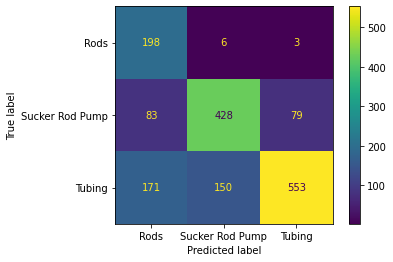

In [21]:
# Plot the confusion matrix
cm = plot_confusion_matrix(best_model, X_test, y_test)

# SHAP 

In [ ]:
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.save_html('RandomShap.html',shap.force_plot(explainer.expected_value[1], shap_values[1], X_test, feature_names = data_cleaning.features(train_data),matplotlib=False))

shap.summary_plot(shap_values, X_test, feature_names = data_cleaning.features(train_data), class_names = ['Rods', 'Sucker Rod Pump', 'Tubing'], show=False)
plt.savefig('summaryPlot.png')